### Reconstruct all test events using four GPUs and the CRS2 spherical optimizer running in batch mode

In [1]:
import pickle
import math
import time
import os
from functools import partial
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from freedom.llh_service.llh_service import LLHService
from freedom.reco import crs_reco
from freedom.reco import summary_df
from freedom.reco import transforms

### Check for a consistent llh service / client installation

In [2]:
import zmq
from freedom.llh_service import llh_cython
assert zmq.zmq_version() == llh_cython.zmq_version(), "Inconsistent zmq installations!"

In [3]:
cvmfs_dir = '/cvmfs/icecube.opensciencegrid.org/users/peller/freeDOM/resources'

In [4]:
with open(f'{cvmfs_dir}/test_events.pkl', 'rb') as f:
    events = pickle.load(f)
# reconstruct about one i3 file's worth of events
events = events[:3000]

In [5]:
params = {'legend.fontsize': 14,
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14}
plt.rcParams.update(params)

### Specify n live points

In [6]:
n_live_points = 97

### Define allowed search ranges and initial box limits

In [7]:
init_range = crs_reco.DEFAULT_INIT_RANGE
param_search_limits = crs_reco.DEFAULT_SEARCH_LIMITS

### llh service configuration:

In [8]:
service_conf = {
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 10,
        "n_evt_features": 2,
        "batch_size" : {
          "n_hypos": 200,
          "n_observations": 6000, 
        },
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "hitnet_file": f"{cvmfs_dir}/HitNet_ranger_06_Sep_2021-18h50/epoch_25_model.hdf5",
        "chargenet_file": f"{cvmfs_dir}/ChargeNet_ranger_23_Aug_2021-18h42/epoch_1500_model.hdf5"
}

In [9]:
# add hit_data, evt_data keys based on the networks being used
for event in events:
    event['hit_data'] = event['hits'][:, :service_conf['n_hit_features']]
    event['evt_data'] = event['total_charge']

In [10]:
# additional structure to enable ICU reco
for event in events:
    event['hit_data'] = [event['hit_data']]
    event['evt_data'] = [event['evt_data']]

### Build four services, one per GPU

In [11]:
n_gpus = 4

In [12]:
base_req = "tcp://127.0.0.1:12340"
base_ctrl = "tcp://127.0.0.1:12350"

req_addrs = []
ctrl_addrs = []
for i in range(n_gpus):
    req_addrs.append(crs_reco.adjust_addr_string(base_req, i))
    ctrl_addrs.append(crs_reco.adjust_addr_string(base_ctrl, i))

In [13]:
print(req_addrs)
print(ctrl_addrs)

['tcp://127.0.0.1:12340', 'tcp://127.0.0.1:12341', 'tcp://127.0.0.1:12342', 'tcp://127.0.0.1:12343']
['tcp://127.0.0.1:12350', 'tcp://127.0.0.1:12351', 'tcp://127.0.0.1:12352', 'tcp://127.0.0.1:12353']


In [14]:
%%capture
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
procs = []
for i in range(n_gpus):
    proc = Process(target=crs_reco.start_service, args=(service_conf, ctrl_addrs[i], req_addrs[i] ,i))
    proc.start()
    procs.append(proc)

### Fit a single event

In [15]:
%%time
test_out = crs_reco.fit_events(events[:1], 0, ctrl_addrs, init_range, 
                               param_search_limits, n_live_points,
                               batch_size=12, spherical_indices=[[4,5]],
                               do_postfit=True,
                               param_transforms=transforms.track_frac_transforms)

CPU times: user 267 ms, sys: 28.4 ms, total: 295 ms
Wall time: 11.2 s


In [16]:
print(f'best fit -LLH: {test_out[0][0]["fun"]:.2f}')
print(f'true params -LLH: {test_out[0][1]:.2f}')
print('---')
print(f'n LLh calls: {test_out[0][0]["n_calls"]}')
print(f'n optimizer iterations: {test_out[0][0]["nit"]}')

best fit -LLH: -38.27
true params -LLH: -24.96
---
n LLh calls: 3909
n optimizer iterations: 204


In [17]:
events_to_process = len(events)
pool_size = 200
evts_per_proc = int(math.ceil(events_to_process/pool_size))
evt_splits = [events[i*evts_per_proc:(i+1)*evts_per_proc] for i in range(pool_size)]
events_to_process

3000

In [18]:
gpu_inds = np.arange(pool_size) % n_gpus

In [19]:
fit_events_partial = partial(
        crs_reco.fit_events,
        ctrl_addrs=ctrl_addrs,
        init_range=init_range,
        search_limits=param_search_limits,
        n_live_points=n_live_points,
        spherical_indices=[[4,5]],
        batch_size=12,
        do_postfit=True,
        param_transforms=transforms.track_frac_transforms)

In [20]:
%%time
start = time.time()
# reconstruct with a worker pool; one LLH client per worker
with Pool(pool_size) as p:
    outs = p.starmap(fit_events_partial, zip(evt_splits, gpu_inds))
delta = time.time() - start

CPU times: user 432 ms, sys: 1.78 s, total: 2.21 s
Wall time: 4min 25s


In [21]:
print(f'measured time: {delta/60:.1f} minutes')

measured time: 4.4 minutes


In [22]:
all_outs = sum((out for out in outs), [])

Note: the following timing is from running on four V100 GPUs in parallel

In [23]:
total_calls = sum(out[0]['n_calls'] for out in all_outs)
total_iters = sum(out[0]['nit'] for out in all_outs)
print(f'{total_calls} total calls')
time_per_call = delta/total_calls
print(f'{total_iters} total iters')
time_per_iter = delta/total_iters
print(f'{total_calls/len(all_outs):.1f} calls per event')
print(f'{time_per_call*1e6:.2f} us per call')

print(f'{total_iters/len(all_outs):.1f} iters per event')
print(f'{time_per_iter*1e6:.2f} us per iter')

13186688 total calls
659757 total iters
4395.6 calls per event
20.10 us per call
219.9 iters per event
401.78 us per iter


In [24]:
par_names = transforms.track_frac_transforms['par_names']
df = summary_df.build_summary_df(all_outs, par_names)

In [25]:
free_f_better = df[df.free_fit_llh < df.true_p_llh]
frac = len(free_f_better) / len(df)
print(f'free fit better frac: {frac:.2f}')

free fit better frac: 0.95


In [26]:
df.to_pickle('./test_out.pkl')

In [27]:
# kill all the services
import zmq
for proc, ctrl_addr in zip(procs, ctrl_addrs): 
    with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
        ctrl_sock.connect(ctrl_addr)
        ctrl_sock.send_string("die")
        proc.join()

Text(0, 0.5, 'n events')

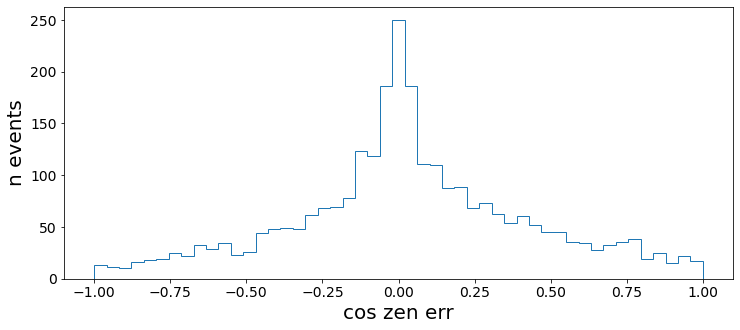

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
zen_ind = par_names.index('zenith')
true_zen = np.array([event['params'][zen_ind] for event in events])
czen_bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith) - np.cos(true_zen), bins=czen_bins, histtype='step')
ax.set_xlabel('cos zen err')
ax.set_ylabel('n events')

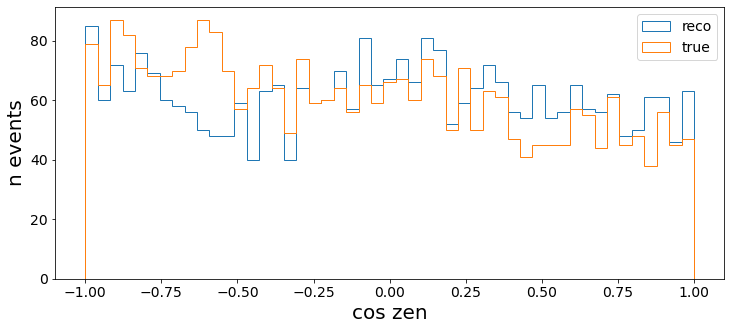

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
true_zen = np.array([event['params'][zen_ind] for event in events])
bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith), bins=bins, histtype='step', label='reco')
ax.hist(np.cos(true_zen), bins=bins, histtype='step', label='true')
ax.set_xlabel('cos zen')
ax.set_ylabel('n events')
ax.legend()